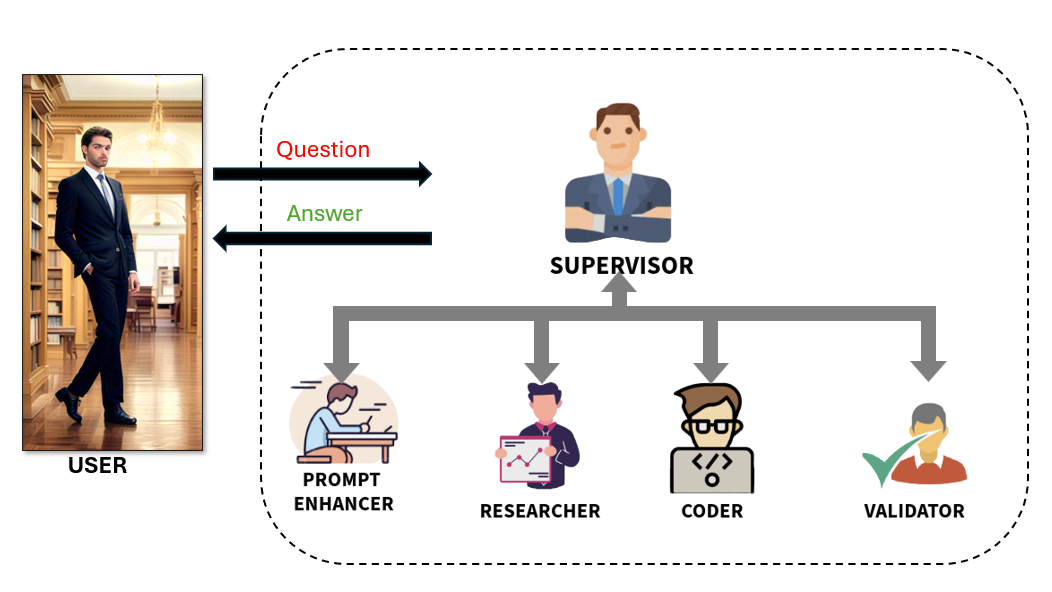


# Multi-Agent Architecture
A multi-agent architecture consists of multiple agents working together to solve a problem or accomplish a task.

## Types of Multi-Agent Architectures:

* **Centralized**: One central controller coordinates the activities of the agents.
* **Decentralized**: No central controller; agents operate independently and communicate to solve tasks collaboratively.
* **Hybrid**: A combination of centralized and decentralized methods, where some coordination is central, and others are independent.

## Key Features
* **Autonomy**: Agents can act independently based on their programming or environment.
* **Cooperation**: Agents may collaborate or share information to achieve a common goal.
* **Adaptability**: Agents can learn from their environment or past actions and adjust their behavior accordingly.



## Install libraries for working with large language models (LLMs).

In [ ]:
!pip install -q langchain langchain_groq langchain_community langgraph rizaio

# Comments:
# - This command installs the required Python libraries:
#   - `langchain`: A framework for building applications powered by language models.
#   - `langchain_groq`: An integration package of LangChain and Groq cloud.
#   - `langchain_community`: Community-contributed tools and utilities for LangChain extension.
#   - `langgraph`: A library for visualizing and managing language model workflows.
#   - `rizaio`: A tool that may be relevant for custom integrations or utilities in this project.
# - The `-q` flag suppresses unnecessary output during installation.


## Retrieve API key from Colab environment

In [ ]:
import os
from google.colab import userdata

# Retrieve the Groq API key from Colab's stored user data and assign it to a variable
groq_api_key = userdata.get('Groq')
os.environ["RIZA_API_KEY"] = userdata.get('code_interpreter_riza')
os.environ["TAVILY_API_KEY"] = userdata.get('Tavily')


# Importing necessary libraries and modules for building a multi-agent architecture


In [ ]:
from typing import Annotated, Sequence, List, Literal # Typing utilities for type hints and better code readability
from pydantic import BaseModel, Field  # `BaseModel` is the base class used to create data models, `Field` is used to provide additional metadata
from langchain_core.messages import HumanMessage # Human message classes for handling human messages in LangChain
from langchain_community.tools.tavily_search import TavilySearchResults # TavilySearchResults for handling external search results
from langchain_community.tools.riza.command import ExecPython # Riza's ExecPython for executing Python code dynamically
from langchain_groq import ChatGroq # Interface for using the ChatGroq platform for advanced language model capabilities
from langgraph.types import Command # LangGraph types for extending commands and functionalities
from langgraph.graph import StateGraph, START, END, MessagesState # Graph-related utilities for building workflows and state machines
from langgraph.prebuilt import create_react_agent # Prebuilt tools and agents for streamlined development
from pprint import pprint # Utilities for debugging and displaying complex data structures in an organized way
from IPython.display import Image, display # Import for displaying images in a Jupyter Notebook

## Initialize a ChatGroq instance using the provided Groq API key and create an LLM object for interaction

In [ ]:
# Initialize a ChatGroq object with a specified API key and model name.
llm = ChatGroq(groq_api_key=groq_api_key, model_name="llama-3.3-70b-versatile")

# Output the ChatGroq object to view its details
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7a9551e07d00>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7a9551e05900>, model_name='llama-3.3-70b-versatile', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [ ]:
llm.invoke('Hi') # calling LLM

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.083636364, 'prompt_time': 0.007229545, 'queue_time': 0.0002124139999999993, 'total_time': 0.090865909}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_fcc3b74982', 'finish_reason': 'stop', 'logprobs': None}, id='run-c04f7130-36be-4bc0-b8b4-dded4ef844d0-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})

In [ ]:
pprint(llm.invoke('Hi'))

AIMessage(content="It's nice to meet you. Is there something I can help you with or would you like to chat?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 36, 'total_tokens': 59, 'completion_time': 0.127700446, 'prompt_time': 0.010792276, 'queue_time': 0.0003543439999999995, 'total_time': 0.138492722}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_c0cfa69934', 'finish_reason': 'stop', 'logprobs': None}, id='run-ce1b2cdc-d042-43d7-bba1-c39cd2842812-0', usage_metadata={'input_tokens': 36, 'output_tokens': 23, 'total_tokens': 59})


In [ ]:
pprint(llm.invoke('how are you?')) # calling LLM

AIMessage(content="I'm just a language model, so I don't have feelings or emotions like humans do, but I'm functioning properly and ready to assist you with any questions or tasks you may have. How can I help you today?", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 46, 'prompt_tokens': 39, 'total_tokens': 85, 'completion_time': 0.167272727, 'prompt_time': 0.007555516, 'queue_time': 6.405299999999968e-05, 'total_time': 0.174828243}, 'model_name': 'llama-3.3-70b-versatile', 'system_fingerprint': 'fp_4e32347616', 'finish_reason': 'stop', 'logprobs': None}, id='run-c156f858-8261-491c-af46-df43aa9e1cae-0', usage_metadata={'input_tokens': 39, 'output_tokens': 46, 'total_tokens': 85})


# Define Tools

In [ ]:
# Initialize the TavilySearchResults tool with a specified maximum number of results.
tool_tavily = TavilySearchResults(max_results=2)

# Initialize the ExecPython tool, which allows executing Python code.
tool_code_interpreter = ExecPython()

# Create a list of tools, combining the TavilySearchResults tool and the ExecPython tool.
tools = [tool_tavily, tool_code_interpreter]



# Define our Supervisor Agent

In [ ]:
system_prompt = ('''You are a workflow supervisor managing a team of three agents: Prompt Enhancer, Researcher, and Coder. Your role is to direct the flow of tasks by selecting the next agent based on the current stage of the workflow. For each task, provide a clear rationale for your choice, ensuring that the workflow progresses logically, efficiently, and toward a timely completion.

**Team Members**:
1. Enhancer: Use prompt enhancer as the first preference, to Focuse on clarifying vague or incomplete user queries, improving their quality, and ensuring they are well-defined before further processing.
2. Researcher: Specializes in gathering information.
3. Coder: Handles technical tasks related to caluclation, coding, data analysis, and problem-solving, ensuring the correct implementation of solutions.

**Responsibilities**:
1. Carefully review each user request and evaluate agent responses for relevance and completeness.
2. Continuously route tasks to the next best-suited agent if needed.
3. Ensure the workflow progresses efficiently, without terminating until the task is fully resolved.

Your goal is to maximize accuracy and effectiveness by leveraging each agent’s unique expertise while ensuring smooth workflow execution.
''')

# Define a Supervisor class to specify the next worker in the pipeline
class Supervisor(BaseModel):
    next: Literal["enhancer", "researcher", "coder"] = Field(
        description="Specifies the next worker in the pipeline: "
                    "'enhancer' for enhancing the user prompt if it is unclear or vague, "
                    "'researcher' for additional information gathering, "
                    "'coder' for solving technical or code-related problems."
    )
    reason: str = Field(
        description="The reason for the decision, providing context on why a particular worker was chosen."
    )

# Define the supervisor node function to handle state transitions
def supervisor_node(state: MessagesState) -> Command[Literal["enhancer", "researcher", "coder"]]:
    """
    Supervisor node for routing tasks based on the current state and LLM response.
    Args:
        state (MessagesState): The current state containing message history.
    Returns:
        Command: A command indicating the next state or action.
    """
    # Prepare messages by appending the system prompt to the message history
    messages = [
        {"role": "system", "content": system_prompt},  # System-level instructions or context
    ] + state["messages"]  # Append previous messages from the state

    # Invoke the language model with structured output using the Router schema
    response = llm.with_structured_output(Supervisor).invoke(messages)
    # Extract the 'next' routing decision and the 'reason' from the response
    goto = response.next
    reason = response.reason
    # Debug logging to trace responses and transitions
    print(f"Current Node:  Supervisor -> Goto: {goto}")
    # print(f"Response: {response}")
    return Command(
        update={
            "messages": [
                # Append the reason (supervisor's response) to the state, tagged with "supervisor"
                HumanMessage(content=reason, name="supervisor")
            ]
        },
        goto=goto,  # Specify the next node in the workflow
    )


In [ ]:
def enhancer_node(state: MessagesState) -> Command[Literal["supervisor"]]:
    """
    Enhancer node for refining and clarifying user inputs.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the enhanced query and route back to the supervisor.
    """
    # Define the system prompt to guide the LLM in query enhancement
    system_prompt = (
        "You are an advanced query enhancer. Your task is to:\n"
        "Don't ask anything to the user, select the most appropriate prompt"
        "1. Clarify and refine user inputs.\n"
        "2. Identify any ambiguities in the query.\n"
        "3. Generate a more precise and actionable version of the original request.\n"
    )

    # Combine the system prompt with the current conversation messages
    messages = [
        {"role": "system", "content": system_prompt},  # Provide context for the LLM
    ] + state["messages"]  # Include the conversation history for context

    # Use the LLM to process the messages and generate an enhanced query
    enhanced_query = llm.invoke(messages)
    print(f"Current Node: Prompt Enhancer -> Goto: Supervisor")
    # print(f"Response: {enhanced_query}")
    # Return a command to update the state with the enhanced query and route back to the supervisor
    return Command(
        update={
            "messages": [  # Append the enhanced query to the message history
                HumanMessage(
                    content=enhanced_query.content,  # Content of the enhanced query
                    name="enhancer"  # Name of the node processing this message
                )
            ]
        },
        goto="supervisor",  # Route to the supervisor for further processing
    )


In [ ]:


def research_node(state: MessagesState) -> Command[Literal["validator"]]:
    """
    Research node for leveraging a ReAct agent to process research-related tasks.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """
    # Create a ReAct agent specialized for research tasks
    research_agent = create_react_agent(
        llm,  # The language model instance used by the agent
        tools=[tool_tavily],  # List of tools the agent can utilize
        state_modifier="You are a researcher. Focus on gathering information and generating content. Do not perform any other tasks"  # Instruction to restrict the agent's behavior
    )
    # Invoke the research agent with the current state to perform its task
    result = research_agent.invoke(state)
    print(f"Current Node: Researcher -> Goto: Validator")
    # print(f"Response:", result)
    # Extract the last message from the result and update the state
    return Command(
        update={
            "messages": [  # Append the research results to the message history
                HumanMessage(
                    content=result["messages"][-1].content,  # Content of the agent's response
                    name="researcher"  # Name of the node generating this message
                )
            ]
        },
        goto="validator",  # Route back to the supervisor for further processing
    )


In [ ]:
def code_node(state: MessagesState) -> Command[Literal["validator"]]:
    """
    Coder node for leveraging a ReAct agent to process analyzing, solving math questions, and executing code.

    Args:
        state (MessagesState): The current state containing the conversation history.

    Returns:
        Command: A command to update the state with the research results and route to the validator.
    """
    # Create a specialized ReAct agent for coding and problem-solving tasks
    code_agent = create_react_agent(
        llm,
        tools=[tool_code_interpreter],
        state_modifier=(
            "You are a coder and analyst. Focus on mathematical caluclations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )

    # Invoke the agent with the current state to process the input and perform its task
    result = code_agent.invoke(state)

    # Debug logging to trace responses and node transitions
    print(f"Current Node: Coder -> Goto: validator")
    # print(f"Response:", result)

    # Return a command to update the state and move to the 'validator' node
    return Command(
        update={
            "messages": [
                # Append the last message (agent's response) to the state, tagged with "coder"
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        # Specify the next node in the workflow: "validator"
        goto="validator",
    )


In [ ]:


# System prompt providing clear instructions to the validator agent
system_prompt = '''
You are a workflow validator. Your task is to ensure the quality of the workflow. Specifically, you must:
- Review the user's question (the first message in the workflow).
- Review the answer (the last message in the workflow).
- If the answer satisfactorily addresses the question, signal to end the workflow.
- If the answer is inappropriate or incomplete, signal to route back to the supervisor for re-evaluation or further refinement.
Ensure that the question and answer match logically and the workflow can be concluded or continued based on this evaluation.

Routing Guidelines:
1. 'supervisor' Agent: For unclear or vague state messages.
2. Respond with 'FINISH' to end the workflow.
'''

# Define a Validator class for structured output from the LLM
class Validator(BaseModel):
    next: Literal["supervisor", "FINISH"] = Field(
        description="Specifies the next worker in the pipeline: 'supervisor' to continue or 'FINISH' to terminate."
    )
    reason: str = Field(
        description="The reason for the decision."
    )

# Define the validator node function to check the user question and the answer
def validator_node(state: MessagesState) -> Command[Literal["supervisor", "__end__"]]:
    """
    Validator node for checking if the question and the answer are appropriate.

    Args:
        state (MessagesState): The current state containing message history.

    Returns:
        Command: A command indicating whether to route back to the supervisor or end the workflow.
    """
    # Extract the first (user's question) and the last (agent's response) messages
    user_question = state["messages"][0].content
    agent_answer = state["messages"][-1].content

    # Prepare the message history with the system prompt
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    # Invoke the LLM with structured output using the Validator schema
    response = llm.with_structured_output(Validator).invoke(messages)

    # Extract the 'next' routing decision and the 'reason' from the response
    goto = response.next
    reason = response.reason



    # Determine the next node in the workflow
    if goto == "FINISH" or goto == END:
        goto = END  # Transition to the termination state
        print("Transitioning to END")  # Debug log to indicate process completion
    else:
        print(f"Current Node: Validator -> Goto: Supervisor")  # Log for routing back to supervisor
    # Debug logging to trace responses and transitions
    # print(f"Response: {response}")
    # Return a command with the updated state and the determined routing destination
    return Command(
        update={
            "messages": [
                # Append the reason (validator's response) to the state, tagged with "validator"
                HumanMessage(content=reason, name="validator")
            ]
        },
        goto=goto,  # Specify the next node in the workflow
    )


In [ ]:
# Initialize the StateGraph with MessagesState to manage the flow of messages between nodes
builder = StateGraph(MessagesState)


builder.add_node("supervisor", supervisor_node)  # Add the supervisor node to the graph
# Add task-specific nodes for various roles in the multi-agent system
builder.add_node("enhancer", enhancer_node)  # Node for refining and clarifying user inputs
builder.add_node("researcher", research_node)  # Node for handling research-related tasks
builder.add_node("coder", code_node)  # Node for managing coding and analytical tasks
builder.add_node("validator", validator_node)  # Node for managing coding and analytical tasks

# Add edges and nodes to define the workflow of the graph
builder.add_edge(START, "supervisor")  # Connect the start node to the supervisor node
# Compile the graph to finalize its structure
graph = builder.compile()


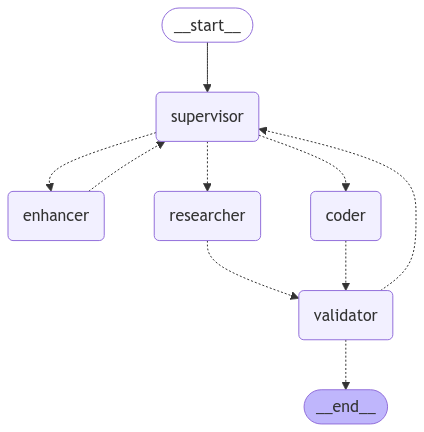

In [ ]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png())) # Display the graph's PNG representation

In [ ]:
import pprint

inputs = {
    "messages": [
        ("user", "wheather in chicago?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Current Node:  Supervisor -> Goto: researcher
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content='The user query about the weather in Chicago is unclear and requires additional information gathering to provide a specific and accurate answer.', additional_kwargs={}, response_metadata={}, name='supervisor', id='77ebe9a9-1cc4-4320-9ebb-153154e1090e')]}

Current Node: Researcher -> Goto: Validator
"Output from node 'researcher':"
{ 'messages': [ HumanMessage(content='The current weather in Chicago is cloudy with a temperature of -0.9°C (30.4°F) and a feels-like temperature of -6.2°C (20.8°F). The wind is blowing at 9.2 mph (14.8 kph) from the south, and the humidity is 65%. There is a 69% cloud cover, and the visibility is 10 km (6 miles). The dew point is -6.6°C (20.1°F), and the UV index is 0.8. Additionally, there is a chance of snow on Friday with winds of 30 to 35 mph.', additional_kwargs={}, response_metadata={}, name='researcher', id='2d138cd0-8a28-4836-969a-21e4f

In [ ]:
inputs = {
    "messages": [
        ("user", "what is difference between the stock price of apple in 2023 and 2021?"),
    ]
}

# Stream through the graph and get output
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        # Get the last message from the output
        last_message = value.get("messages", [])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}':")
            pprint.pprint(last_message, indent=2, width=80, depth=None)
            print()

Current Node:  Supervisor -> Goto: researcher
"Output from node 'supervisor':"
HumanMessage(content="The user's question requires real-time or historical data on Apple's stock price, which needs to be gathered or researched.", additional_kwargs={}, response_metadata={}, name='supervisor', id='a64fc7e7-58b8-4cd6-8ab6-e87f172eef08')

Current Node: Researcher -> Goto: Validator
"Output from node 'researcher':"
HumanMessage(content="According to the search results, the closing price for Apple (AAPL) in 2021 was $191.80, and in 2023 it was $191.59. This means that the stock price decreased by $0.21 between 2021 and 2023. However, it's also mentioned that the latest price is $224.53 and $242.86 respectively, indicating a significant increase in the stock price over time.", additional_kwargs={}, response_metadata={}, name='researcher', id='fd792a44-759e-43df-af8d-098c01fe1a3c')

Transitioning to END
"Output from node 'validator':"
HumanMessage(content='The answer satisfactorily addresses the 

In [ ]:

inputs = {
    "messages": [
        ("user", "Research the impact of climate change on agriculture in Southeast Asia. Based on your findings, propose potential solutions to mitigate its effects on crop production"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Current Node:  Supervisor -> Goto: researcher
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content="The user's request requires in-depth research and analysis of the impact of climate change on agriculture in Southeast Asia to propose potential solutions.", additional_kwargs={}, response_metadata={}, name='supervisor', id='159e54f5-c9ce-4cab-9295-8a09f31ac468')]}

Current Node: Researcher -> Goto: Validator
"Output from node 'researcher':"
{ 'messages': [ HumanMessage(content='Based on the search results, potential solutions to mitigate the effects of climate change on agriculture in Southeast Asia include:\n\n1. Implementing regenerative agriculture practices, such as alternate wetting and drying, to optimize soil carbon stocks and reduce greenhouse gas emissions.\n2. Adopting alternative farming techniques, crop diversification, and water management strategies to mitigate climate risks and maintain productivity.\n3. Enhancing water management, sustainable practices, 

In [ ]:

inputs = {
    "messages": [
        ("user", "give me how many A's present in a string of AVYGABAAHKJHDAAAAUHBU  ?"),
    ]
}
for output in graph.stream(inputs):
    for key, value in output.items():
        if value is None:
            continue
        pprint.pprint(f"Output from node '{key}':")
        pprint.pprint(value, indent=2, width=80, depth=None)
        print()

Current Node:  Supervisor -> Goto: coder
"Output from node 'supervisor':"
{ 'messages': [ HumanMessage(content='The user has provided a specific string and is asking for the number of times a particular character appears in it, which requires a technical solution.', additional_kwargs={}, response_metadata={}, name='supervisor', id='04658c7a-b6a0-411a-9b0d-6184e40bf0aa')]}

Current Node: Coder -> Goto: validator
"Output from node 'coder':"
{ 'messages': [ HumanMessage(content="The character 'A' appears 8 times in the given string.", additional_kwargs={}, response_metadata={}, name='coder', id='959d235a-3ab3-40da-8599-e2c886e064db')]}

Transitioning to END
"Output from node 'validator':"
{ 'messages': [ HumanMessage(content='The answer is clear and directly addresses the question.', additional_kwargs={}, response_metadata={}, name='validator', id='0be903e8-b82e-470f-8945-3daa27ddb4bd')]}

